In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import scipy, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sl_m
from sklearn.preprocessing import PowerTransformer
from sklearn_pandas import DataFrameMapper
from statsmodels.tools.tools import add_constant
import statsmodels.regression.linear_model as sm_lm
import statsmodels.stats.outliers_influence as sm_ol
import statsmodels.stats.diagnostic as sm_diag
from mlxtend.regressor import StackingRegressor

pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Base data has significant autocorrelation at 20+ lags, so in order to avoid building a complex and hardly-interpretable ARIMA model, we will analyze 2016 year across the countries.

In [2]:
df=pd.read_excel("../input/data2.xlsx")
ldrop=[]
for i in range(len(df)):
    if df['Year'][i] not in [2016]:
        ldrop.append(i)
df=df.drop(index=ldrop)
df=df.drop(columns='Year')
x = list(df.columns.values)
x.remove('Country Name')
mapper = DataFrameMapper([(df[x].columns, PowerTransformer())])
df[x] = mapper.fit_transform(df[x])
df = add_constant(df)
X_train, Y_train = df.drop(labels=['Country Name', 'Life expectancy'], axis = 1), df['Life expectancy']

df2=pd.read_excel("../input/data2.xlsx")
ldrop=[]
for i in range(len(df)):
    if df2['Year'][i] in [2016]:
        ldrop.append(i)
df2=df2.drop(index=ldrop)
df2=df2.drop(columns='Year')
x = list(df2.columns.values)
x.remove('Country Name')
mapper = DataFrameMapper([(df2[x].columns, PowerTransformer())])
df2[x] = mapper.fit_transform(df2[x])
df2 = add_constant(df2)
X_test, Y_test = df2.drop(labels=['Country Name', 'Life expectancy'], axis = 1), df2['Life expectancy']

Most of the variables seem to have more or less linear relation to TL.

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


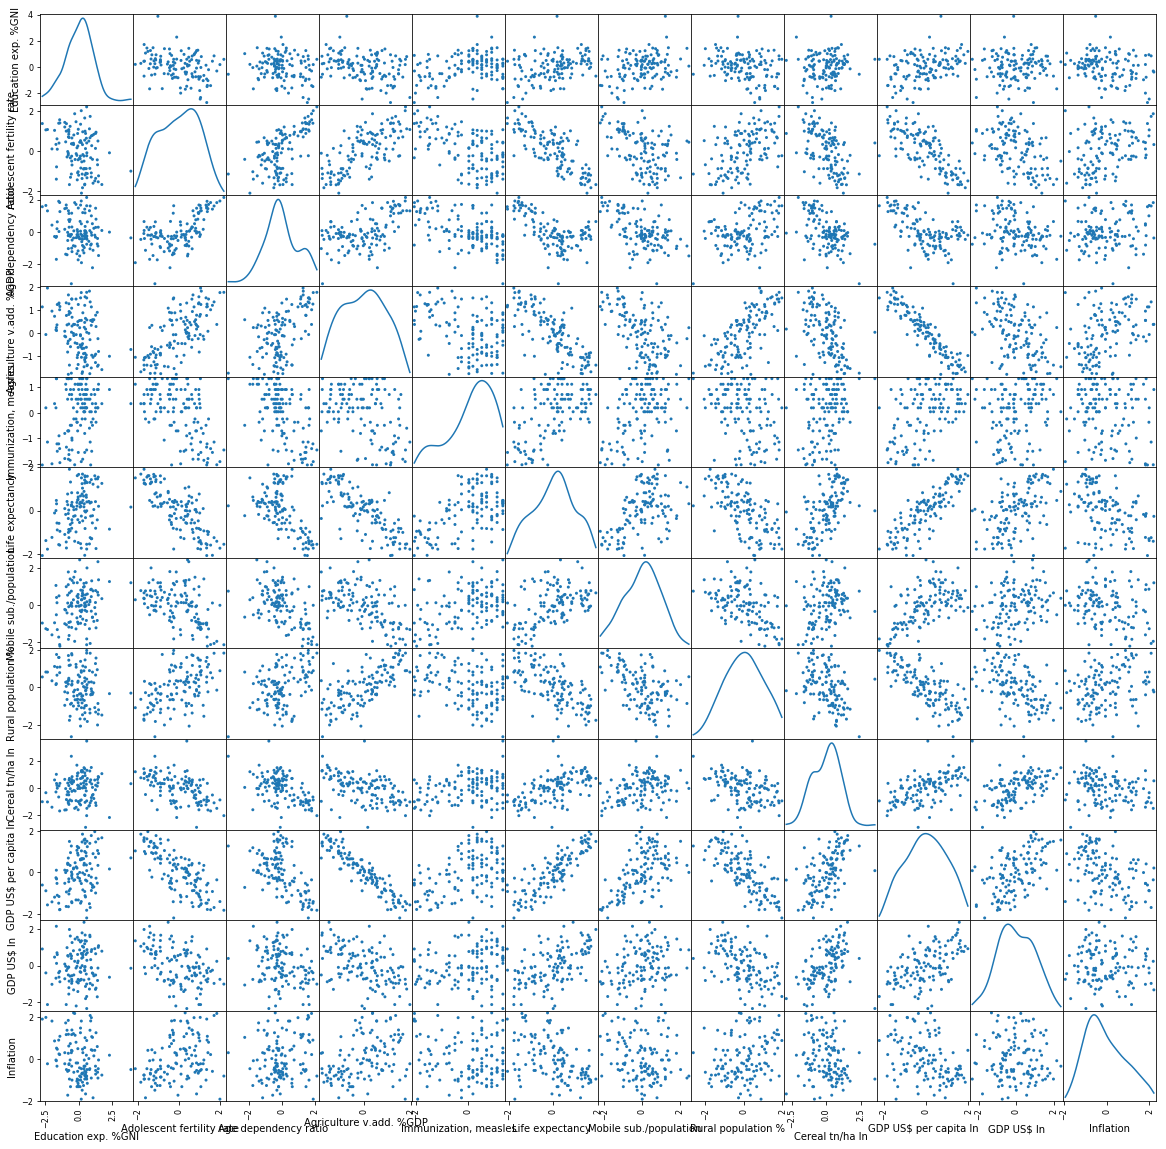

In [3]:
x = list(df.columns.values)
x.remove('const')
f,ax = plt.subplots(figsize=(20, 20))
pd.plotting.scatter_matrix(df[x], ax=ax, alpha=1, diagonal="kde")
plt.show()

In [4]:
columns=list(df.columns.values)
columns.remove('Country Name')
columns.remove('Life expectancy')

In [5]:
pd.Series([sm_ol.variance_inflation_factor(df[columns].values, i) for i in range(df[columns].shape[1])], index=columns)

const                        1.000
Education exp. %GNI          1.278
Adolescent fertility rate    3.088
Age dependency ratio         2.248
Agriculture v.add. %GDP      7.843
Immunization, measles        1.662
Mobile sub./population       1.749
Rural population %           2.465
Cereal tn/ha ln              1.748
GDP US$ per capita ln       12.037
GDP US$ ln                   1.794
Inflation                    1.330
dtype: float64

In [6]:
for x in columns:
    reg=sm_lm.OLS(df['Life expectancy'], df[['const', x]]).fit()
    bp=sm_diag.het_breuschpagan(reg.resid, reg.model.exog)
    print(x)
    print("LM_stat= " + str(bp[0]) + " lm_pvalue= " + str(bp[1]) + " fvalue= " + str(bp[2]) + " f_pvalue= " + str(bp[3]))
    print(" ")
reg=sm_lm.OLS(df['Life expectancy'], df[columns]).fit()
bp=sm_diag.het_breuschpagan(reg.resid, reg.model.exog)
print('reg')
print("LM_stat= " + str(bp[0]) + " lm_pvalue= " + str(bp[1]) + " fvalue= " + str(bp[2]) + " f_pvalue= " + str(bp[3]))
print(" ")

const
LM_stat= 5.46229728115577e-14 lm_pvalue= 0.9999998135219463 fvalue= inf f_pvalue= nan
 
Education exp. %GNI
LM_stat= 4.795060875942603 lm_pvalue= 0.02854144796866157 fvalue= 4.908444353413405 f_pvalue= 0.028596770725787413
 
Adolescent fertility rate
LM_stat= 1.7966376874672148 lm_pvalue= 0.18011951415541944 fvalue= 1.793623180378168 f_pvalue= 0.1829956368133388
 
Age dependency ratio
LM_stat= 0.3935373900616185 lm_pvalue= 0.5304458354939218 fvalue= 0.38838102970924204 f_pvalue= 0.5343245437228854
 
Agriculture v.add. %GDP
LM_stat= 1.795326051226097 lm_pvalue= 0.18027858112805467 fvalue= 1.7922943490625671 f_pvalue= 0.18315671019734708
 
Immunization, measles
LM_stat= 1.9634819062325501 lm_pvalue= 0.16114142390713942 fvalue= 1.9628895014154601 f_pvalue= 0.16376413086581598
 
Mobile sub./population
LM_stat= 4.05704159255543 lm_pvalue= 0.043987498870837846 fvalue= 4.1272055048235785 f_pvalue= 0.04438934769626152
 
Rural population %
LM_stat= 0.1441588800285859 lm_pvalue= 0.70418103

Heteroskedasticity is insignificant on all variables set, but confirmed separately in education, mob. sub., and inflation.

In [7]:
for x in columns:
    st,p = scipy.stats.normaltest(df[x],nan_policy='omit')
    print(x + " p-value = " + str('%.3f' % p))

const p-value = 0.595
Education exp. %GNI p-value = 0.073
Adolescent fertility rate p-value = 0.001
Age dependency ratio p-value = 0.948
Agriculture v.add. %GDP p-value = 0.000
Immunization, measles p-value = 0.001
Mobile sub./population p-value = 0.673
Rural population % p-value = 0.234
Cereal tn/ha ln p-value = 0.476
GDP US$ per capita ln p-value = 0.004
GDP US$ ln p-value = 0.450
Inflation p-value = 0.019


In [8]:
columns=list(df.columns.values)
columns.remove('Country Name')
columns.remove('Life expectancy')

In [9]:
reg=sm_lm.OLS(df['Life expectancy'], df[columns]).fit()
df2=df.copy()
df2['res']=reg.resid
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     47.88
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           5.23e-37
Time:                        13:02:42   Log-Likelihood:                -67.009
No. Observations:                 123   AIC:                             158.0
Df Residuals:                     111   BIC:                             191.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.139e-07      0.040  -2.88e-06      1.000      -0.078       0.078
Education exp. %GNI           0.0043      0.045      0.097      0.923      -0.084       0.093
Adolescent fertility rate    -0.2239      0.070     -3.218      0.002      -0.362      -0.086
Age dependency ratio         -0.0437      0.059     -0.737      0.463      -0.161       0.074
Agriculture v.add. %GDP       0.0770      0.111      0.695      0.489      -0.143       0.297
Immunization, measles         0.1618      0.051      3.168      0.002       0.061       0.263
Mobile sub./population       -0.0423      0.052     -0.808      0.421      -0.146       0.061
Rural population %           -0.0693      0.062     -1.115      0.267      -0.193       0.054
Cereal tn/ha ln               0.0994      0.052      1.899      0.060      -0.004       0.203
GDP US$ per capita ln         0.4643      0.137      3.380      0.001       0.192       0.737
GDP US$ ln                    0.0955      0.053      1.801      0.074      -0.010       0.201
Inflation                    -0.1403      0.046     -3.073      0.003      -0.231      -0.050
==============================================================================
Omnibus:                        2.764   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.586
Skew:                          -0.355   Prob(JB):                        0.274
Kurtosis:                       2.962   Cond. No.                         9.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Residuals are normal despite many variables are not, so we can use OLS.

Constant is insignificant and has low value, dropped.

In [10]:
st,p = scipy.stats.normaltest(df2['res'])
print(x + " p-value = " + str('%.3f' % p))

Inflation p-value = 0.251


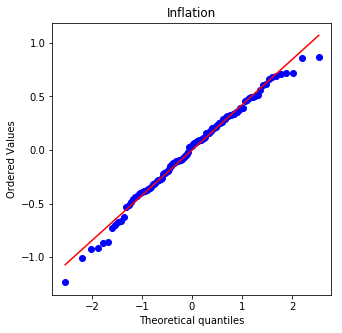

In [11]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
scipy.stats.probplot(df2['res'], dist="norm", plot=ax)
ax.set_title(x)
plt.show()

In [12]:
columns=list(df.columns.values)
columns.remove('Country Name')
columns.remove('Life expectancy')
columns.remove('const')
columns.remove('GDP US$ per capita ln')

reg=sm_lm.OLS(df['Life expectancy'], df[columns]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     47.56
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           6.98e-36
Time:                        13:02:43   Log-Likelihood:                -73.032
No. Observations:                 123   AIC:                             166.1
Df Residuals:                     113   BIC:                             194.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Education exp. %GNI           0.0231      0.046      0.500      0.618      -0.068       0.115
Adolescent fertility rate    -0.2841      0.070     -4.058      0.000      -0.423      -0.145
Age dependency ratio         -0.0487      0.062     -0.788      0.432      -0.171       0.074
Agriculture v.add. %GDP      -0.2018      0.077     -2.617      0.010      -0.355      -0.049
Immunization, measles         0.1766      0.053      3.336      0.001       0.072       0.282
Mobile sub./population       -0.0293      0.054     -0.538      0.591      -0.137       0.078
Rural population %           -0.1339      0.062     -2.175      0.032      -0.256      -0.012
Cereal tn/ha ln               0.1319      0.054      2.463      0.015       0.026       0.238
GDP US$ ln                    0.1365      0.054      2.540      0.012       0.030       0.243
Inflation                    -0.1578      0.047     -3.341      0.001      -0.251      -0.064
==============================================================================
Omnibus:                        5.837   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.311
Skew:                          -0.476   Prob(JB):                       0.0703
Kurtosis:                       3.358   Cond. No.                         4.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With GDP per capita removed, R2 adj decreased, so it wasnt a good change from the original model. Education exp. %GNI and Mobile sub./population are insignificant in both versions so we can remove them instead. After several iterations we arrive at the final version of model.

Model (backup spec)

In [13]:
columns=list(df.columns.values)
columns.remove('Country Name')
columns.remove('Life expectancy')
columns.remove('const')
columns.remove('Education exp. %GNI')
columns.remove('Mobile sub./population')
columns.remove('GDP US$ per capita ln')
#columns.remove('GDP US$ ln')
columns.remove('Age dependency ratio')
#columns.remove('Agriculture v.add. %GDP')
#columns.remove('Rural population %')

reg=sm_lm.OLS(df['Life expectancy'], df[columns]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     69.09
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           2.04e-38
Time:                        13:02:43   Log-Likelihood:                -73.500
No. Observations:                 123   AIC:                             161.0
Df Residuals:                     116   BIC:                             180.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Adolescent fertility rate    -0.2999      0.067     -4.488      0.000      -0.432      -0.168
Agriculture v.add. %GDP      -0.2038      0.074     -2.742      0.007      -0.351      -0.057
Immunization, measles         0.1879      0.049      3.810      0.000       0.090       0.286
Rural population %           -0.1337      0.060     -2.226      0.028      -0.253      -0.015
Cereal tn/ha ln               0.1432      0.050      2.839      0.005       0.043       0.243
GDP US$ ln                    0.1271      0.052      2.442      0.016       0.024       0.230
Inflation                    -0.1546      0.046     -3.348      0.001      -0.246      -0.063
==============================================================================
Omnibus:                        4.055   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.611
Skew:                          -0.411   Prob(JB):                        0.164
Kurtosis:                       3.166   Cond. No.                         4.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model (main spec)

In [14]:
columns=list(df.columns.values)
columns.remove('Country Name')
columns.remove('Life expectancy')
columns.remove('const')
columns.remove('Education exp. %GNI')
columns.remove('Mobile sub./population')
#columns.remove('GDP US$ per capita ln')
columns.remove('GDP US$ ln')
columns.remove('Age dependency ratio')
columns.remove('Agriculture v.add. %GDP')
columns.remove('Rural population %')

reg=sm_lm.OLS(df['Life expectancy'], df[columns]).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life expectancy   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     104.6
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           1.15e-41
Time:                        13:02:43   Log-Likelihood:                -70.470
No. Observations:                 123   AIC:                             150.9
Df Residuals:                     118   BIC:                             165.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Adolescent fertility rate    -0.2391      0.066     -3.627      0.000      -0.370      -0.109
Immunization, measles         0.1547      0.047      3.261      0.001       0.061       0.249
Cereal tn/ha ln               0.1274      0.049      2.619      0.010       0.031       0.224
GDP US$ per capita ln         0.4877      0.066      7.399      0.000       0.357       0.618
Inflation                    -0.1096      0.043     -2.526      0.013      -0.196      -0.024
==============================================================================
Omnibus:                        2.549   Durbin-Watson:                   2.175
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.586
Skew:                          -0.328   Prob(JB):                        0.274
Kurtosis:                       2.730   Cond. No.                         3.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When any additional year is included, most of the variables are no longer normally distributed, as well as residuals, and HS tests are positive. Despite this, models' parameters and their significance are practically the same, and R2 on the test sample is also around 82%. Algorithmic models show far better overall accuracy with larger training sets.

In [15]:
print('manually constructed model')
print('train acc ' + str(sl_m.r2_score(Y_train, reg.predict(X_train[columns]))))
print("test  acc " + str(sl_m.r2_score(Y_test, reg.predict(X_test[columns]))))
print("test  EVS "  + str(sl_m.explained_variance_score(Y_test, reg.predict(X_test[columns]))))
print("test  MAE "  + str(sl_m.mean_absolute_error(Y_test, reg.predict(X_test[columns]))))
print("test  MSE "  + str(sl_m.mean_squared_error(Y_test, reg.predict(X_test[columns]))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, reg.predict(X_test[columns]))))

manually constructed model
train acc 0.8158527444183828
test  acc 0.8173807241841071
test  EVS 0.8173807241841071
test  MAE 0.33204950951292395
test  MSE 0.18261927581589293
test MdAE 0.27099202166009756


Accuracy metrics are highly correlated, so we can use R2 as a main metric and Median AE for outliers.

Now we will add more data to the training sample to get better tuning from the ensembles.

In [16]:
df=pd.read_excel("../input/data2.xlsx")
ldrop=[]
for i in range(len(df)):
    if df['Year'][i] not in [1996, 1997, 1998, 1999, 2000]:
        ldrop.append(i)
df=df.drop(index=ldrop)
df=df.drop(columns='Year')
x = list(df.columns.values)
x.remove('Country Name')
mapper = DataFrameMapper([(df[x].columns, PowerTransformer())])
df[x] = mapper.fit_transform(df[x])
df = add_constant(df)
X_train, Y_train = df.drop(labels=['Country Name', 'Life expectancy'], axis = 1), df['Life expectancy']

df2=pd.read_excel("../input/data2.xlsx")
ldrop=[]
for i in range(len(df)):
    if df2['Year'][i] in [1996, 1997, 1998, 1999, 2000]:
        ldrop.append(i)
df2=df2.drop(index=ldrop)
df2=df2.drop(columns='Year')
x = list(df2.columns.values)
x.remove('Country Name')
mapper = DataFrameMapper([(df2[x].columns, PowerTransformer())])
df2[x] = mapper.fit_transform(df2[x])
df2 = add_constant(df2)
X_test, Y_test = df2.drop(labels=['Country Name', 'Life expectancy'], axis = 1), df2['Life expectancy']

In [17]:
print('manually constructed model')
print('train acc ' + str(sl_m.r2_score(Y_train, reg.predict(X_train[columns]))))
print("test  acc " + str(sl_m.r2_score(Y_test, reg.predict(X_test[columns]))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, reg.predict(X_test[columns]))))

manually constructed model
train acc 0.8302395498115502
test  acc 0.8155674788707372
test MdAE 0.2694194969217458


In [18]:
rfr=RandomForestRegressor(random_state=17, n_estimators=100)
rfr.fit(X_train, Y_train)
print('random forset regr')
print('train acc ' + str(sl_m.r2_score(Y_train, rfr.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, rfr.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, rfr.predict(X_test))))

random forset regr
train acc 0.9958307167923921
test  acc 0.8879433339722316
test MdAE 0.2008117188461468


Random forest shows better accuracy, and high stability on test dataset with larger training sample.

Decision tree:

In [19]:
dtr=DecisionTreeRegressor()
dtr.fit(X_train, Y_train)
print('train acc ' + str(sl_m.r2_score(Y_train, dtr.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, dtr.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, dtr.predict(X_test))))

train acc 0.9999999991409774
test  acc 0.7927880140619483
test MdAE 0.24007036722528324


"Optimized" with GS:

In [20]:
dtg = GridSearchCV(DecisionTreeRegressor(), param_grid = {'criterion':['mse','friedman_mse','mae'], 'splitter':['best','random'],
                                                         'max_depth':range(1,30), 'max_features':range(1,12)}, cv=3)
dtg.fit(X_train, Y_train)
print(dtg.best_params_)
print('train acc ' + str(sl_m.r2_score(Y_train, dtg.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, dtg.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, dtg.predict(X_test))))

{'criterion': 'friedman_mse', 'max_depth': 4, 'max_features': 9, 'splitter': 'best'}
train acc 0.9008120145766614
test  acc 0.7798630163140289
test MdAE 0.2706903257010157


Neighbors regression:

In [21]:
knr=KNeighborsRegressor()
knr.fit(X_train, Y_train)
print('KNN regr')
print('train acc ' + str(sl_m.r2_score(Y_train, knr.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, knr.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, knr.predict(X_test))))

KNN regr
train acc 0.9773514959408657
test  acc 0.8969096634990757
test MdAE 0.19996288897183756


"Optimal" settings with GS as well show worse accuracy than default ones.

In [22]:
knr_grid = GridSearchCV(KNeighborsRegressor(), param_grid = {'n_neighbors':range(5,10), 'weights':['uniform', 'distance'],
                                                             'algorithm':['ball_tree', 'kd_tree', 'brute'], 'p':[1,2]}, cv=3)
knr_grid.fit(X_train, Y_train)
print(knr_grid.best_params_)
print('train acc ' + str(sl_m.r2_score(Y_train, knr_grid.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, knr_grid.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, knr_grid.predict(X_test))))

{'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
train acc 0.9438786318676924
test  acc 0.895736859519317
test MdAE 0.20377881798747982


Bagging(KNeighborsRegressor), didnt perform better compared to simple KNR.

In [23]:
bag_KNR=BaggingRegressor(KNeighborsRegressor(), n_estimators = 20, random_state = 17)
bag_KNR.fit(X_train, Y_train)
print('train acc ' + str(sl_m.r2_score(Y_train, bag_KNR.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, bag_KNR.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, bag_KNR.predict(X_test))))

train acc 0.9745785502486493
test  acc 0.8999798623584544
test MdAE 0.20071076564101875


Stochastic Gradient Descent shows similar results to manual model (with parameters optimized with GS), but a better with outliers.

In [24]:
sgd = SGDRegressor(max_iter=1500, penalty='l1', l1_ratio=0.1)
sgd.fit(X_train, Y_train)
print('SDG regr')
print('train acc ' + str(sl_m.r2_score(Y_train, sgd.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, sgd.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, sgd.predict(X_test))))

SDG regr
train acc 0.8472283165370205
test  acc 0.8235320547477469
test MdAE 0.2753556428886541


Log regression wont be used in model ensemble due to being classification tool and requiring type(Y)=int.

In [25]:
logr=LogisticRegression()
logr.fit(X_train, Y_train.apply(lambda x: x*10000).astype(int))
print('log regr')
print('train acc ' + str(sl_m.r2_score(Y_train.apply(lambda x: x*10000).astype(int), logr.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test.apply(lambda x: x*10000).astype(int), logr.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test.apply(lambda x: x*10000).astype(int), logr.predict(X_test))/10000))

log regr
train acc 0.9056054927960295
test  acc 0.7276544852088155
test MdAE 0.25985


Ensemble:

In [26]:
ens1=StackingRegressor(regressors=[dtr, knr, rfr], meta_regressor = sgd)
ens1.fit(X_train, Y_train)
print('SDG regr')
print('train acc ' + str(sl_m.r2_score(Y_train, ens1.predict(X_train))))
print("test  acc " + str(sl_m.r2_score(Y_test, ens1.predict(X_test))))
print("test MdAE "  + str(sl_m.median_absolute_error(Y_test, ens1.predict(X_test))))

SDG regr
train acc 0.9998298187412165
test  acc 0.8402613118725175
test MdAE 0.2235725286966496


Main observation from testing:

Algorithmic models have a really good approximation when given a representative time series dataset to train (for example [1996, 2001, 2006, 2011, 2016]) which reflects the data at most of its possible states. A simple decision tree with such dataset has 90%+ R2 and about 0.07 MdAE. However, when we give an input based on successive years [1996, 1997, 1998, 1999, 2000] and make a prediction for other years, most of the models perform on the level of a manually constructed one. Simple KN regression shows good results in both cases.

Ensemble with [1996, 2001, 2006, 2011, 2016] train data shows the accuracy of the best of components - a simple decision tree reg. In case of [1996, 1997, 1998, 1999, 2000] it shows worse accuracy than many models.